# Importing Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline

# Preprocessing

In [ ]:
# set the directory of the data set file
FILE_DIR = ''
data = pd.read_csv(FILE_DIR)

'''
Cabeçalho csv:
ano_periodo,turma,
pp1,pp2,pp3,pp4,pp5,pp6,pp7,pp8,pp9,pp10,pp11,pp12,pp13,pp14,pp15,pp16,pp17,pp18,pp19,pp20,
pv1,pv2,pv3,pv4,pv5,pv6,pv7,pv8,pv9,pv10,pv11,pv12,pv13,pv14,pv15,pv16,pv17,pv18,pv19,pv20,
f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,
ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,ch16,ch17,ch18,ch19,ch20,
nota_unidade_1_imd0901,nota_unidade_2_imd0901,nota_unidade_3_imd0901,nota_unidade_4_imd0901,faltas_imd0901,recuperacao_imd0901,media_final_imd0901,
nota_unidade_1_imd0902,nota_unidade_2_imd0902,nota_unidade_3_imd0902,nota_unidade_4_imd0902,faltas_imd0902,recuperacao_imd0902,media_final_imd0902,
nota_unidade_1_imd0908,nota_unidade_2_imd0908,nota_unidade_3_imd0908,nota_unidade_4_imd0908,faltas_imd0908,recuperacao_imd0908,media_final_imd0908,
nota_unidade_1_imd0909,nota_unidade_2_imd0909,nota_unidade_3_imd0909,nota_unidade_4_imd0909,faltas_imd0909,recuperacao_imd0909,media_final_imd0909,
nota_unidade_1_imd0930,nota_unidade_2_imd0930,nota_unidade_3_imd0930,nota_unidade_4_imd0930,faltas_imd0930,recuperacao_imd0930,media_final_imd0930,
nota_unidade_1_imd0931,nota_unidade_2_imd0931,nota_unidade_3_imd0931,nota_unidade_4_imd0931,faltas_imd0931,recuperacao_imd0931,media_final_imd0931,
faltas_modulo,media_modulo,situacao_modulo

Módulo: Módulo Básico V3
Ano de execução: 2015 a 2020

Disciplinas:
IMD0901 - INTRODUÇÃO ÀS TECNOLOGIAS DA INFORMAÇÃO (60h)
IMD0902 - INGLES TECNICO I (40h)
IMD0908 - SISTEMAS OPERACIONAIS (60h)
IMD0909 - ARQUITETURA DE COMPUTADORES (20h)
IMD0930 - MATEMÁTICA APLICADA (40h)
IMD0931 - LÓGICA DE PROGRAMAÇÃO (60h)

Unidades:
1. AP - Atividades Presenciais
2. PV - Participação Virtual
3. EV - Execícios no Ambiente Virtual
4. PP - Prova Escrita Presencial

Pesos das notas nas unidades:
Até 2018: 3 notas, pesos: 1,1,2 (12.5,12.5,25,50), a partir de 2019: 4 notas, pesos: 25,10,15,50
'''

data['aprovado'] = np.where(data['situacao_modulo'] == 'APROVADO', True, (np.where(data['situacao_modulo'] == 'APROVADO POR NOTA', True, False)))
data['cancelado'] = np.where(data['situacao_modulo'] == 'CANCELADO', True, False)

data_mm = data.copy()
data_mm.dropna(subset=['media_modulo'], inplace=True)
Xmm = np.array([(x, x) for x in data_mm['media_modulo']])

kmeans_3classes = KMeans(n_clusters=3).fit(Xmm)
data_mm['nivel_de_risco'] = kmeans_3classes.predict(Xmm)

semesters = ['2015.1','2016.1','2017.1','2017.2','2018.1','2019.1','2020.1']
cod_classes = ['IMD0901','IMD0902','IMD0908','IMD0909','IMD0930','IMD0931']
classes = ['IMD0901 - INTRODUÇÃO ÀS TECNOLOGIAS DA INFORMAÇÃO (60h)','IMD0902 - INGLES TECNICO I (40h)','IMD0908 - SISTEMAS OPERACIONAIS (60h)','IMD0909 - ARQUITETURA DE COMPUTADORES (20h)','IMD0930 - MATEMÁTICA APLICADA (40h)','IMD0931 - LÓGICA DE PROGRAMAÇÃO (60h)']

filtered_data = data.query('cancelado == False')
filtered_data_mm = data_mm.query('cancelado == False')

#print(filtered_data['aprovado'].value_counts())
#print(filtered_data['aprovado'].value_counts(normalize=True))

#print(filtered_data_mm['nivel_de_risco'].value_counts())
#print(filtered_data_mm['nivel_de_risco'].value_counts(normalize=True))

#print(kmeans_3classes.cluster_centers_)

# Data Visualization

## 1. Final Result



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


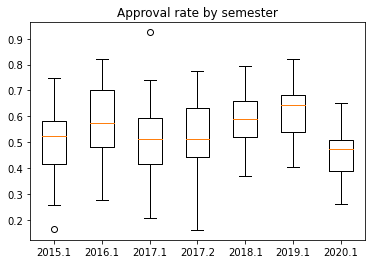

In [ ]:
groupedData = data.groupby(['ano_periodo'])
semester = []
pctSucess = []

for name, group in groupedData:
    semester.append(name)
    dataApr = group.query('aprovado == True')
    groupedApr = dataApr.groupby(['turma'])
    groupedAprCount = groupedApr.count()
    apr = list(groupedAprCount['aprovado'])

    groupedTotal = group.groupby(['turma'])
    groupedTotalCount = groupedTotal.count()
    total = list(groupedTotalCount['aprovado'])

    pctAprovacao = [a/t for a, t in zip(apr, total)]
    pctSucess.append(pctAprovacao)

fig, ax = plt.subplots()
ax.boxplot(pctSucess)
plt.xticks(np.arange(start=1, stop=8), semester)
ax.set_title("Approval rate by semester")

plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


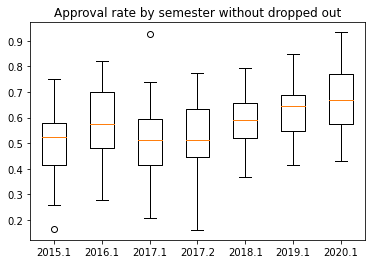

In [ ]:
groupedData = data.groupby(['ano_periodo'])
semester = []
pctSucess = []

for name, group in groupedData:
    semester.append(name)
    dataApr = group.query('aprovado == True')
    groupedApr = dataApr.groupby(['turma'])
    groupedAprCount = groupedApr.count()
    apr = list(groupedAprCount['aprovado'])

    dataNotCan = group.query('cancelado == False')
    groupedTotal = dataNotCan.groupby(['turma'])
    groupedTotalCount = groupedTotal.count()
    total = list(groupedTotalCount['aprovado'])

    pctAprovacao = [a/t for a, t in zip(apr, total)]
    pctSucess.append(pctAprovacao)

fig, ax = plt.subplots()
ax.boxplot(pctSucess)
plt.xticks(np.arange(start=1, stop=8), semester)
ax.set_title("Approval rate by semester without dropped out")

plt.show()

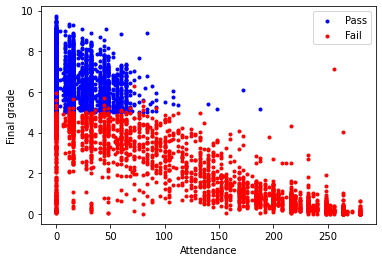

In [ ]:
dataApr = data.query('aprovado == True')
XApr = dataApr['faltas_modulo']
YApr = dataApr['media_modulo']

dataRep = data.query('aprovado == False')
XRep = dataRep['faltas_modulo']
YRep = dataRep['media_modulo']

fig, ax = plt.subplots()
ax.scatter(XApr, YApr, color="blue", marker='.', label="Pass")
ax.scatter(XRep, YRep, color="red", marker='.', label="Fail")
ax.set_xlabel("Attendance")
ax.set_ylabel("Final grade")
plt.legend()

plt.show()

## 2. Classes Results

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


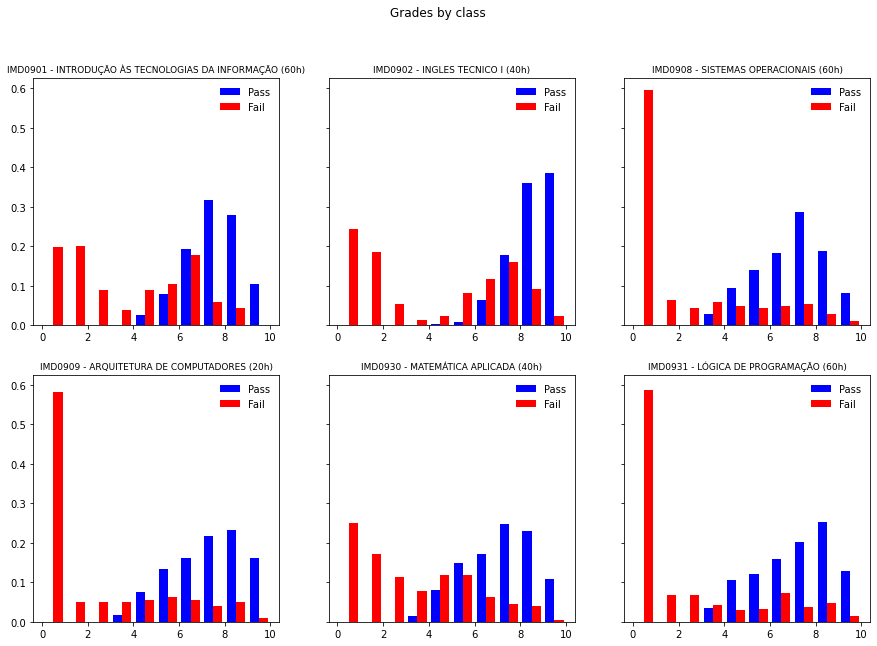

In [ ]:
grades = []

dataApr = group.query('aprovado == True')
dataRep = group.query('aprovado == False')

grades.append((dataApr['media_final_imd0901'], dataRep['media_final_imd0901']))
grades.append((dataApr['media_final_imd0902'], dataRep['media_final_imd0902']))
grades.append((dataApr['media_final_imd0908'], dataRep['media_final_imd0908']))
grades.append((dataApr['media_final_imd0909'], dataRep['media_final_imd0909']))
grades.append((dataApr['media_final_imd0930'], dataRep['media_final_imd0930']))
grades.append((dataApr['media_final_imd0931'], dataRep['media_final_imd0931']))

fig, ax = plt.subplots(2, 3, sharey=True, figsize=(15,10))
for i, a in enumerate(fig.axes):
    a.hist(grades[i], density=True, stacked=False, color=['blue','red'], label=['Pass','Fail'], range=(0, 10))
    a.legend(frameon=False)
    a.set_title(classes[i], fontsize=9)

fig.suptitle('Grades by class')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


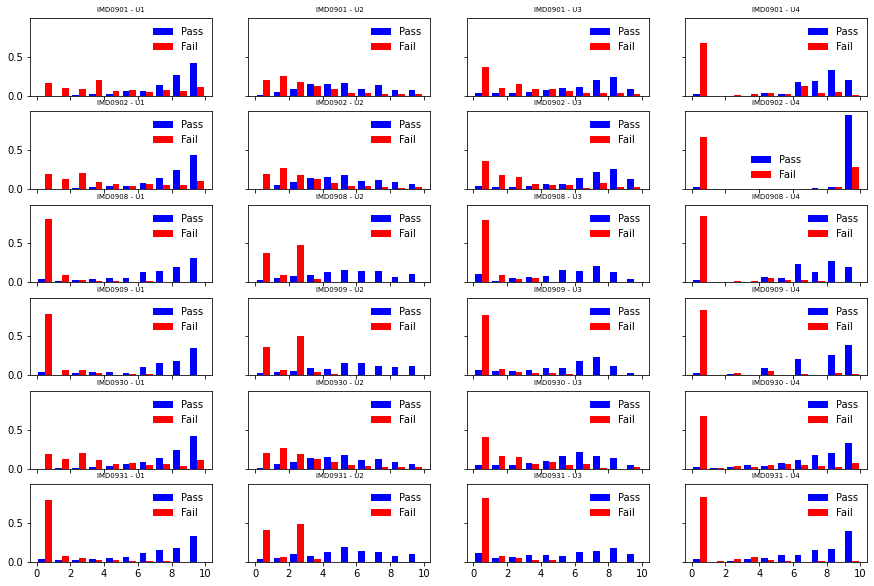

In [ ]:
n = [1, 2, 3, 4]
unidades = []
grades = []

for c in cod_classes:
    for u in n:
        unidades.append('{} - U{}'.format(c, u))

dataApr = group.query('aprovado == True')
dataRep = group.query('aprovado == False')

grades.append((dataApr['nota_unidade_1_imd0901'], dataRep['nota_unidade_1_imd0901']))
grades.append((dataApr['nota_unidade_2_imd0901'], dataRep['nota_unidade_2_imd0901']))
grades.append((dataApr['nota_unidade_3_imd0901'], dataRep['nota_unidade_3_imd0901']))
grades.append((dataApr['nota_unidade_4_imd0901'], dataRep['nota_unidade_4_imd0901']))

grades.append((dataApr['nota_unidade_1_imd0902'], dataRep['nota_unidade_1_imd0902']))
grades.append((dataApr['nota_unidade_2_imd0902'], dataRep['nota_unidade_2_imd0902']))
grades.append((dataApr['nota_unidade_3_imd0902'], dataRep['nota_unidade_3_imd0902']))
grades.append((dataApr['nota_unidade_4_imd0902'], dataRep['nota_unidade_4_imd0902']))

grades.append((dataApr['nota_unidade_1_imd0908'], dataRep['nota_unidade_1_imd0908']))
grades.append((dataApr['nota_unidade_2_imd0908'], dataRep['nota_unidade_2_imd0908']))
grades.append((dataApr['nota_unidade_3_imd0908'], dataRep['nota_unidade_3_imd0908']))
grades.append((dataApr['nota_unidade_4_imd0908'], dataRep['nota_unidade_4_imd0908']))

grades.append((dataApr['nota_unidade_1_imd0909'], dataRep['nota_unidade_1_imd0909']))
grades.append((dataApr['nota_unidade_2_imd0909'], dataRep['nota_unidade_2_imd0909']))
grades.append((dataApr['nota_unidade_3_imd0909'], dataRep['nota_unidade_3_imd0909']))
grades.append((dataApr['nota_unidade_4_imd0909'], dataRep['nota_unidade_4_imd0909']))

grades.append((dataApr['nota_unidade_1_imd0930'], dataRep['nota_unidade_1_imd0930']))
grades.append((dataApr['nota_unidade_2_imd0930'], dataRep['nota_unidade_2_imd0930']))
grades.append((dataApr['nota_unidade_3_imd0930'], dataRep['nota_unidade_3_imd0930']))
grades.append((dataApr['nota_unidade_4_imd0930'], dataRep['nota_unidade_4_imd0930']))

grades.append((dataApr['nota_unidade_1_imd0931'], dataRep['nota_unidade_1_imd0931']))
grades.append((dataApr['nota_unidade_2_imd0931'], dataRep['nota_unidade_2_imd0931']))
grades.append((dataApr['nota_unidade_3_imd0931'], dataRep['nota_unidade_3_imd0931']))
grades.append((dataApr['nota_unidade_4_imd0931'], dataRep['nota_unidade_4_imd0931']))

fig, ax = plt.subplots(6, 4, sharex=True, sharey=True, figsize=(15,10))
for i, a in enumerate(fig.axes):
    a.hist(grades[i], density=True, stacked=False, color=['blue','red'], label=['Pass','Fail'], range=(0, 10))
    a.legend(frameon=False)
    a.set_title(unidades[i], fontsize=7)

plt.show()

Effects of different weights of tasks

In [ ]:
filteredData = data.query('ano_periodo == \'2019.1\'')
resultado = []
solucoes = [(12.5,12.5,25.0,50.0), (25.0,10.0,15.0,50.0)]

for i, j, k, l in solucoes:
    aprovados = 0.0
    total = 0.0
    for ind in filteredData.index:
        mediaDiscente = 0.0
        pesos = 0.0
        aprovado = True

        ch = 60
        media = (i*filteredData['nota_unidade_1_imd0901'][ind] + j*filteredData['nota_unidade_2_imd0901'][ind] + k*filteredData['nota_unidade_3_imd0901'][ind] + l*filteredData['nota_unidade_4_imd0901'][ind])/(i+j+k+l)
        mediaDiscente += ch*media
        pesos += ch
        if media < 3.0:
            aprovado = False

        ch = 40
        media = (i*filteredData['nota_unidade_1_imd0902'][ind] + j*filteredData['nota_unidade_2_imd0902'][ind] + k*filteredData['nota_unidade_3_imd0902'][ind] + l*filteredData['nota_unidade_4_imd0902'][ind])/(i+j+k+l)
        mediaDiscente += ch*media
        pesos += ch
        if media < 3.0:
            aprovado = False

        ch = 60
        media = (i*filteredData['nota_unidade_1_imd0908'][ind] + j*filteredData['nota_unidade_2_imd0908'][ind] + k*filteredData['nota_unidade_3_imd0908'][ind] + l*filteredData['nota_unidade_4_imd0908'][ind])/(i+j+k+l)
        mediaDiscente += ch*media
        pesos += ch
        if media < 3.0:
            aprovado = False

        ch = 20
        media = (i*filteredData['nota_unidade_1_imd0909'][ind] + j*filteredData['nota_unidade_2_imd0909'][ind] + k*filteredData['nota_unidade_3_imd0909'][ind] + l*filteredData['nota_unidade_4_imd0909'][ind])/(i+j+k+l)
        mediaDiscente += ch*media
        pesos += ch
        if media < 3.0:
            aprovado = False

        ch = 40
        media = (i*filteredData['nota_unidade_1_imd0930'][ind] + j*filteredData['nota_unidade_2_imd0930'][ind] + k*filteredData['nota_unidade_3_imd0930'][ind] + l*filteredData['nota_unidade_4_imd0930'][ind])/(i+j+k+l)
        mediaDiscente += ch*media
        pesos += ch
        if media < 3.0:
            aprovado = False

        ch = 60
        media = (i*filteredData['nota_unidade_1_imd0931'][ind] + j*filteredData['nota_unidade_2_imd0931'][ind] + k*filteredData['nota_unidade_3_imd0931'][ind] + l*filteredData['nota_unidade_4_imd0931'][ind])/(i+j+k+l)
        mediaDiscente += ch*media
        pesos += ch
        if media < 3.0:
            aprovado = False

        mediaDiscente = mediaDiscente/pesos
        if mediaDiscente < 5.0:
            aprovado = False
        if aprovado:
            aprovados += 1.0
        total += 1.0
    resultado.append(((i,j,k,l), aprovados/total))

resultado.sort(key = lambda x: x[1])
print(resultado)

[((12.5, 12.5, 25.0, 50.0), 0.46214511041009465), ((25.0, 10.0, 15.0, 50.0), 0.4921135646687697)]


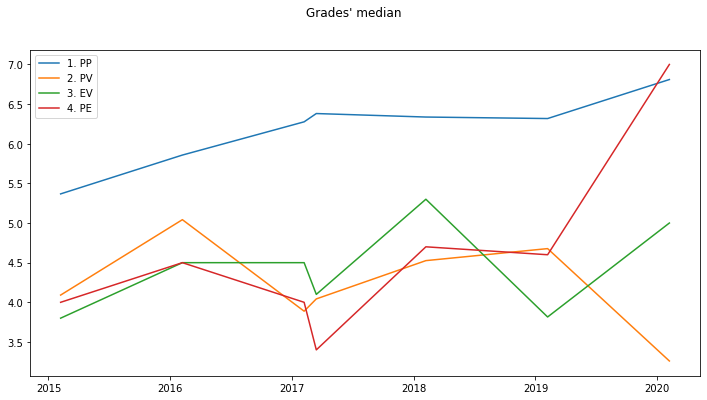

In [ ]:
groupedData = data.groupby(['ano_periodo'])

periodos = []
notas1 = []
notas2 = []
notas3 = []
notas4 = []

for name, group in groupedData:
    periodos.append(name)
    
    n1 = list(group['nota_unidade_1_imd0901'])
    n1.extend(group['nota_unidade_1_imd0902'])
    n1.extend(group['nota_unidade_1_imd0908'])
    n1.extend(group['nota_unidade_1_imd0909'])
    n1.extend(group['nota_unidade_1_imd0930'])
    n1.extend(group['nota_unidade_1_imd0931'])
    n1 = pd.DataFrame(n1, columns=['nota'])

    n2 = list(group['nota_unidade_2_imd0901'])
    n2.extend(group['nota_unidade_2_imd0902'])
    n2.extend(group['nota_unidade_2_imd0908'])
    n2.extend(group['nota_unidade_2_imd0909'])
    n2.extend(group['nota_unidade_2_imd0930'])
    n2.extend(group['nota_unidade_2_imd0931'])
    n2 = pd.DataFrame(n2, columns=['nota'])

    n3 = list(group['nota_unidade_3_imd0901'])
    n3.extend(group['nota_unidade_3_imd0902'])
    n3.extend(group['nota_unidade_3_imd0908'])
    n3.extend(group['nota_unidade_3_imd0909'])
    n3.extend(group['nota_unidade_3_imd0930'])
    n3.extend(group['nota_unidade_3_imd0931'])
    n3 = pd.DataFrame(n3, columns=['nota'])

    n4 = list(group['nota_unidade_4_imd0901'])
    n4.extend(group['nota_unidade_4_imd0902'])
    n4.extend(group['nota_unidade_4_imd0908'])
    n4.extend(group['nota_unidade_4_imd0909'])
    n4.extend(group['nota_unidade_4_imd0930'])
    n4.extend(group['nota_unidade_4_imd0931'])
    n4 = pd.DataFrame(n4, columns=['nota'])

    notas1.append(n1.median())
    notas2.append(n2.median())
    notas3.append(n3.median())
    notas4.append(n4.median())

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(periodos, notas1, label='1. PP')
ax.plot(periodos, notas2, label='2. PV')
ax.plot(periodos, notas3, label='3. EV')
ax.plot(periodos, notas4, label='4. PE')
ax.legend()

fig.suptitle('Grades\' median')
plt.show()

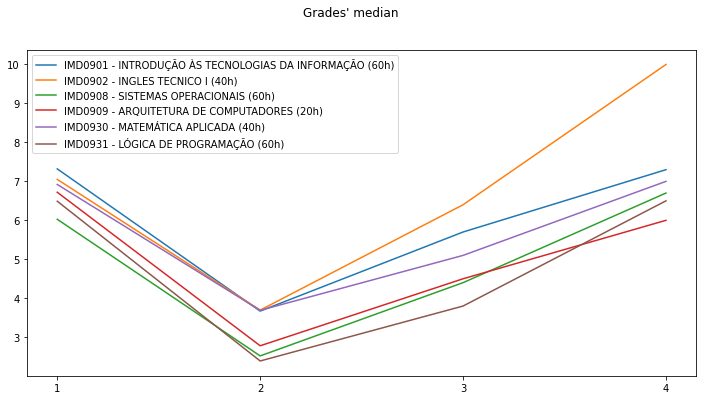

In [ ]:
disciplinasNotas = []

grades = []
grades.append(group['nota_unidade_1_imd0901'].median())
grades.append(group['nota_unidade_2_imd0901'].median())
grades.append(group['nota_unidade_3_imd0901'].median())
grades.append(group['nota_unidade_4_imd0901'].median())
disciplinasNotas.append(('IMD0901 - INTRODUÇÃO ÀS TECNOLOGIAS DA INFORMAÇÃO (60h)', grades))

grades = []
grades.append(group['nota_unidade_1_imd0902'].median())
grades.append(group['nota_unidade_2_imd0902'].median())
grades.append(group['nota_unidade_3_imd0902'].median())
grades.append(group['nota_unidade_4_imd0902'].median())
disciplinasNotas.append(('IMD0902 - INGLES TECNICO I (40h)', grades))

grades = []
grades.append(group['nota_unidade_1_imd0908'].median())
grades.append(group['nota_unidade_2_imd0908'].median())
grades.append(group['nota_unidade_3_imd0908'].median())
grades.append(group['nota_unidade_4_imd0908'].median())
disciplinasNotas.append(('IMD0908 - SISTEMAS OPERACIONAIS (60h)', grades))

grades = []
grades.append(group['nota_unidade_1_imd0909'].median())
grades.append(group['nota_unidade_2_imd0909'].median())
grades.append(group['nota_unidade_3_imd0909'].median())
grades.append(group['nota_unidade_4_imd0909'].median())
disciplinasNotas.append(('IMD0909 - ARQUITETURA DE COMPUTADORES (20h)', grades))

grades = []
grades.append(group['nota_unidade_1_imd0930'].median())
grades.append(group['nota_unidade_2_imd0930'].median())
grades.append(group['nota_unidade_3_imd0930'].median())
grades.append(group['nota_unidade_4_imd0930'].median())
disciplinasNotas.append(('IMD0930 - MATEMÁTICA APLICADA (40h)', grades))

grades = []
grades.append(group['nota_unidade_1_imd0931'].median())
grades.append(group['nota_unidade_2_imd0931'].median())
grades.append(group['nota_unidade_3_imd0931'].median())
grades.append(group['nota_unidade_4_imd0931'].median())
disciplinasNotas.append(('IMD0931 - LÓGICA DE PROGRAMAÇÃO (60h)', grades))

fig, ax = plt.subplots(figsize=(12,6))
for d, n in disciplinasNotas:
    ax.plot(np.arange(1, 5), n, label=d)
ax.legend()
plt.xticks(np.arange(start=1, stop=5))

fig.suptitle('Grades\' median')
plt.show()

## 3. Weekly Results

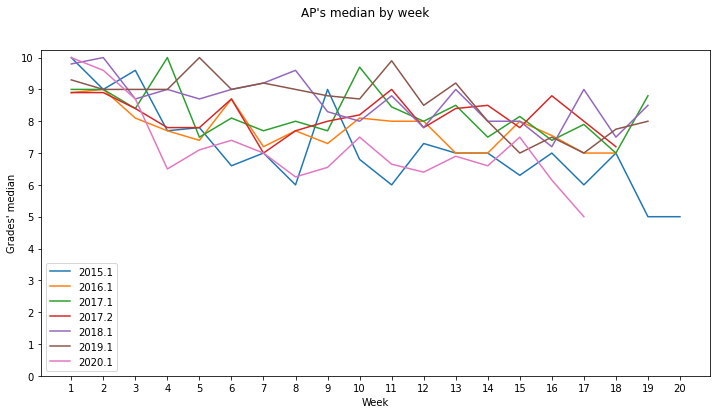

In [ ]:
groupedData = [data.query('ano_periodo == \'2015.1\''), data.query('ano_periodo == \'2016.1\''), data.query('ano_periodo == \'2017.1\''), data.query('ano_periodo == \'2017.2\''), data.query('ano_periodo == \'2018.1\''), data.query('ano_periodo == \'2019.1\''), data.query('ano_periodo == \'2020.1\'')]
fig, ax = plt.subplots(figsize=(12,6))

for i, g in zip(semesters, groupedData):
    grades = []
    grades.append(g['pp1'].median())
    grades.append(g['pp2'].median())
    grades.append(g['pp3'].median())
    grades.append(g['pp4'].median())
    grades.append(g['pp5'].median())
    grades.append(g['pp6'].median())
    grades.append(g['pp7'].median())
    grades.append(g['pp8'].median())
    grades.append(g['pp9'].median())
    grades.append(g['pp10'].median())
    grades.append(g['pp11'].median())
    grades.append(g['pp12'].median())
    grades.append(g['pp13'].median())
    grades.append(g['pp14'].median())
    grades.append(g['pp15'].median())
    grades.append(g['pp16'].median())
    grades.append(g['pp17'].median())
    grades.append(g['pp18'].median())
    grades.append(g['pp19'].median())
    grades.append(g['pp20'].median())
    ax.plot(np.arange(start=1, stop=21), grades, label=i)

ax.legend()
plt.xticks(np.arange(start=1, stop=21))
plt.yticks(np.arange(start=0.0, stop=11.0))
ax.set_xlabel("Week")
ax.set_ylabel("Grades' median")

fig.suptitle('AP\'s median by week')
plt.show()

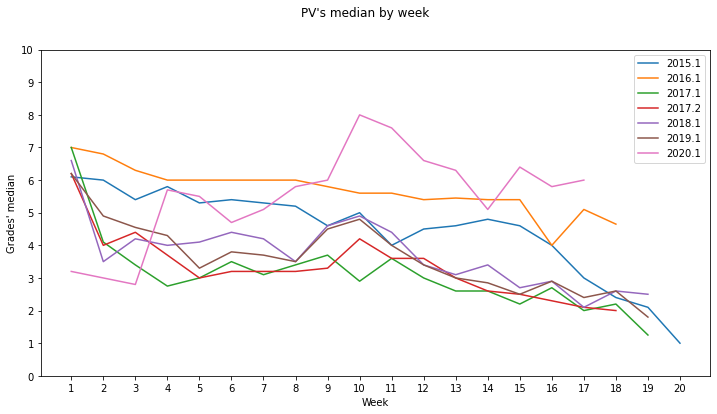

In [ ]:
groupedData = [data.query('ano_periodo == \'2015.1\''), data.query('ano_periodo == \'2016.1\''), data.query('ano_periodo == \'2017.1\''), data.query('ano_periodo == \'2017.2\''), data.query('ano_periodo == \'2018.1\''), data.query('ano_periodo == \'2019.1\''), data.query('ano_periodo == \'2020.1\'')]
fig, ax = plt.subplots(figsize=(12,6))

for i, g in zip(periodos, groupedData):
    grades = []
    grades.append(g['pv1'].median())
    grades.append(g['pv2'].median())
    grades.append(g['pv3'].median())
    grades.append(g['pv4'].median())
    grades.append(g['pv5'].median())
    grades.append(g['pv6'].median())
    grades.append(g['pv7'].median())
    grades.append(g['pv8'].median())
    grades.append(g['pv9'].median())
    grades.append(g['pv10'].median())
    grades.append(g['pv11'].median())
    grades.append(g['pv12'].median())
    grades.append(g['pv13'].median())
    grades.append(g['pv14'].median())
    grades.append(g['pv15'].median())
    grades.append(g['pv16'].median())
    grades.append(g['pv17'].median())
    grades.append(g['pv18'].median())
    grades.append(g['pv19'].median())
    grades.append(g['pv20'].median())
    ax.plot(np.arange(start=1, stop=21), grades, label=i)

ax.legend()
plt.xticks(np.arange(start=1, stop=21))
plt.yticks(np.arange(start=0.0, stop=11.0))
ax.set_xlabel("Week")
ax.set_ylabel("Grades' median")

fig.suptitle('PV\'s median by week')
plt.show()

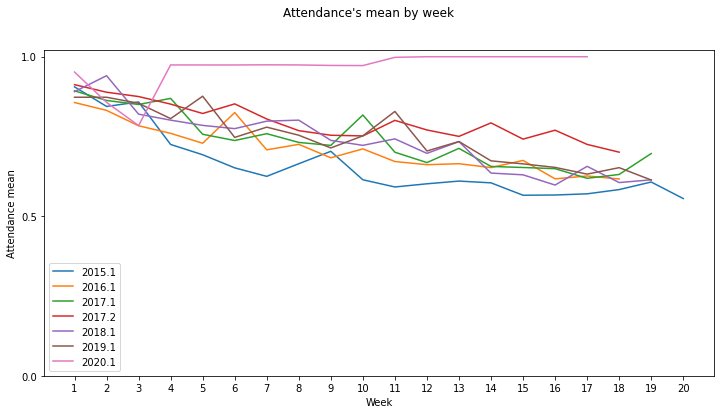

In [ ]:
groupedData = [data.query('ano_periodo == \'2015.1\''), data.query('ano_periodo == \'2016.1\''), data.query('ano_periodo == \'2017.1\''), data.query('ano_periodo == \'2017.2\''), data.query('ano_periodo == \'2018.1\''), data.query('ano_periodo == \'2019.1\''), data.query('ano_periodo == \'2020.1\'')]
fig, ax = plt.subplots(figsize=(12,6))

for i, g in zip(periodos, groupedData):
    grades = []
    grades.append(g['f1'].mean())
    grades.append(g['f2'].mean())
    grades.append(g['f3'].mean())
    grades.append(g['f4'].mean())
    grades.append(g['f5'].mean())
    grades.append(g['f6'].mean())
    grades.append(g['f7'].mean())
    grades.append(g['f8'].mean())
    grades.append(g['f9'].mean())
    grades.append(g['f10'].mean())
    grades.append(g['f11'].mean())
    grades.append(g['f12'].mean())
    grades.append(g['f13'].mean())
    grades.append(g['f14'].mean())
    grades.append(g['f15'].mean())
    grades.append(g['f16'].mean())
    grades.append(g['f17'].mean())
    grades.append(g['f18'].mean())
    grades.append(g['f19'].mean())
    grades.append(g['f20'].mean())
    ax.plot(np.arange(start=1, stop=21), grades, label=i)

ax.legend()
plt.xticks(np.arange(start=1, stop=21))
plt.yticks([0.0, 0.5, 1.0])
ax.set_xlabel("Week")
ax.set_ylabel("Attendance mean")

fig.suptitle('Attendance\'s mean by week')
plt.show()

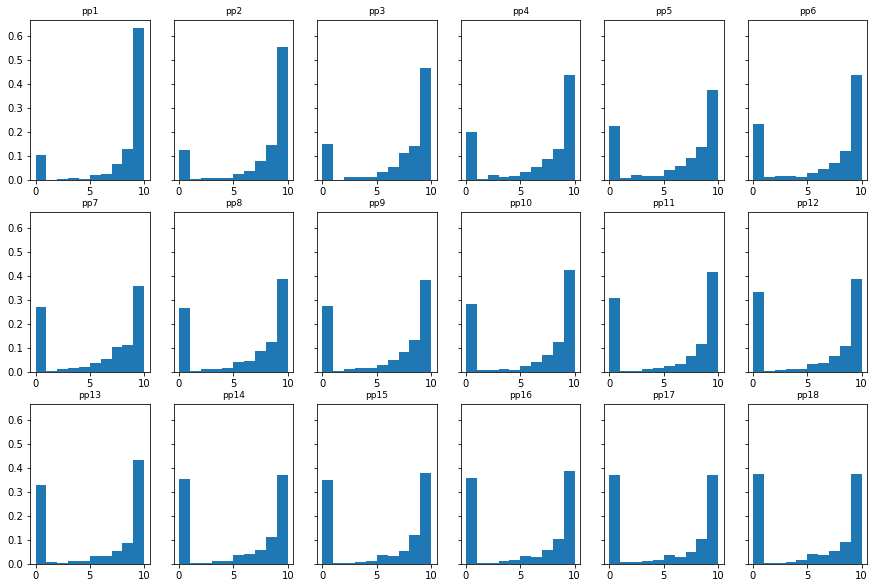

In [ ]:
attr = ['pp{}'.format(n) for n in range(1,19)]

grades = []
for a in attr:
  grades.append(filtered_data[a])

fig, ax = plt.subplots(3, 6, sharey=True, figsize=(15,10))
for i, a in enumerate(fig.axes):
    a.hist(grades[i], density=True)
    a.set_title('pp{}'.format(i+1), fontsize=9)

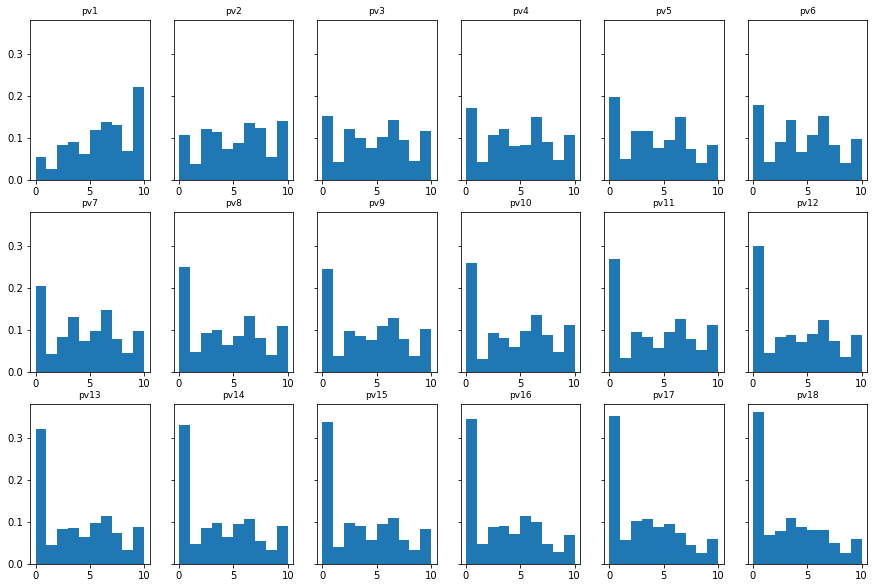

In [ ]:
attr =  ['pv{}'.format(n) for n in range(1,19)]

grades = []
for a in attr:
  grades.append(filtered_data[a])

fig, ax = plt.subplots(3, 6, sharey=True, figsize=(15,10))
for i, a in enumerate(fig.axes):
    a.hist(grades[i], density=True)
    a.set_title('pv{}'.format(i+1), fontsize=9)

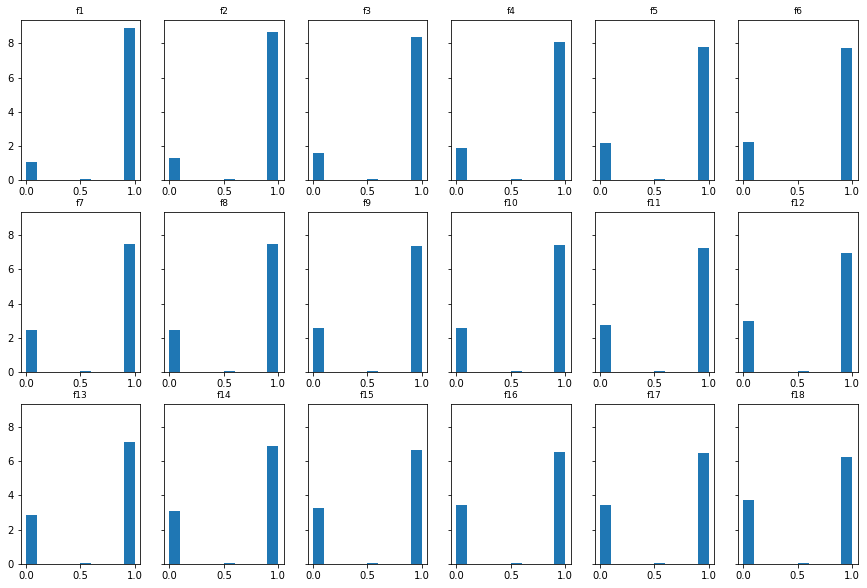

In [ ]:
attr =  ['f{}'.format(n) for n in range(1,19)]

grades = []
for a in attr:
  grades.append(filtered_data[a])

fig, ax = plt.subplots(3, 6, sharey=True, figsize=(15,10))
for i, a in enumerate(fig.axes):
    a.hist(grades[i], density=True)
    a.set_title('f{}'.format(i+1), fontsize=9)

In [ ]:
attr = ['pp1','pp2','pp3','pp4','pp5','pp6','pp7','pp8','pp9','pp10','pp11','pp12','pp13','pp14','pp15','pp16','pp17','pp18','pv1','pv2','pv3','pv4','pv5','pv6','pv7','pv8','pv9','pv10','pv11','pv12','pv13','pv14','pv15','pv16','pv17','pv18']
values = [round(filtered_data[i].mean(),2) for i in attr]
print(values)

[8.12, 7.69, 7.23, 6.71, 6.27, 6.44, 5.95, 6.11, 6.08, 6.18, 6.0, 5.68, 5.82, 5.51, 5.57, 5.49, 5.32, 5.31, 6.01, 5.08, 4.68, 4.51, 4.21, 4.44, 4.34, 4.16, 4.18, 4.26, 4.19, 3.83, 3.7, 3.57, 3.51, 3.38, 3.13, 3.11]


# Data Analysis

## Classification

### Classifiers' Comparison (KNN, Naive Bayes, Logistic Regression and Random Forest)

In [ ]:
scores = ['accuracy']
scores_keys = ['test_{}'.format(i) for i in scores]
imp = SimpleImputer()
scaler = MinMaxScaler()

def confusionMatrixScorer(clf, X, y):
  y_pred = clf.predict(X)
  cm = confusion_matrix(y, y_pred)
  return {'tn': cm[0, 0], 'fp': cm[0, 1], 'fn': cm[1, 0], 'tp': cm[1, 1]}

def runClassifierWithSemesterFolding(dataset, y_label, clf, attr_set=['pp','pv','f'], length=19):
  results_map = {n: [] for n in scores_keys}
  for i in range(1, length):
    attr = ['ano_periodo']
    attr.append(y_label)
    if 'pp' in attr_set:
      attr.extend(['pp{}'.format(n) for n in range(1,i+1)])
    if 'pv' in attr_set:
      attr.extend(['pv{}'.format(n) for n in range(1,i+1)])
    if 'f' in attr_set:
      attr.extend(['f{}'.format(n) for n in range(1,i+1)])
    X = dataset.loc[:, tuple(attr)]
  
    scores = []
    for ap in semesters:
      ano_periodo = [ap]
      X_train, X_test = X.query('ano_periodo not in @ano_periodo'), X.query('ano_periodo in @ano_periodo')
      y_train, y_test = X_train[y_label], X_test[y_label]
      del X_train[y_label]
      del X_train['ano_periodo']
      del X_test[y_label]
      del X_test['ano_periodo']
  
      imp = SimpleImputer()
      scaler = MinMaxScaler()
      pipeline = Pipeline([('imp', imp), ('scaler', scaler), ('clf', clf)])
  
      rf = pipeline.fit(X_train, y_train)
  
      scores.append(rf.score(X_test, y_test))
    results_map['test_accuracy'].append(np.average(scores))
  return results_map

def runClassifierForAllWeeksCV(dataset, y_label, clf, attr_set=['pp','pv','f'], length=19):
  results_map = {n: [] for n in scores_keys}
  pipeline = Pipeline([('imp', imp), ('scaler', scaler), ('clf', clf)])

  for i in range(1, length):
    attr = [y_label]
    if 'pp' in attr_set:
      attr.extend(['pp{}'.format(n) for n in range(1,i+1)])
    if 'pv' in attr_set:
      attr.extend(['pv{}'.format(n) for n in range(1,i+1)])
    if 'f' in attr_set:
      attr.extend(['f{}'.format(n) for n in range(1,i+1)])
    X = dataset.loc[:, tuple(attr)]
    y = X[y_label]
    del X[y_label]

    cvs = cross_validate(pipeline, X, y, scoring=scores, cv=4, return_estimator=True)

    for sk in scores_keys:
      results_map[sk].append(np.average(cvs[sk]))

  return results_map

def runClassifierForAllWeeksHoldout(dataset, y_label, clf, attr_set=['pp','pv','f'], length=19):
  results_map = {n: [] for n in scores_keys}
  pipeline = Pipeline([('imp', imp), ('scaler', scaler), ('clf', clf)])

  for i in range(1, length):
    attr = [y_label]
    if 'pp' in attr_set:
      attr.extend(['pp{}'.format(n) for n in range(1,i+1)])
    if 'pv' in attr_set:
      attr.extend(['pv{}'.format(n) for n in range(1,i+1)])
    if 'f' in attr_set:
      attr.extend(['f{}'.format(n) for n in range(1,i+1)])
    X = dataset.loc[:, tuple(attr)]
    y = X[y_label]
    del X[y_label]

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    pipeline.fit(X_train, y_train)

    for sk in scores_keys:
      results_map[sk].append(accuracy_score(y_test, pipeline.predict(X_test)))

  return results_map

In [ ]:
lr = LogisticRegression(max_iter=500,solver='newton-cg')

dataset = filtered_data_mm
y = 'nivel_de_risco'

lr_binary = runClassifierWithSemesterFolding(dataset, y, lr)
lr_binary2 = runClassifierWithSemesterFolding(dataset, y, lr, ['pp','pv'])
lr_binary3 = runClassifierWithSemesterFolding(dataset, y, lr, ['pp'])
lr_binary4 = runClassifierWithSemesterFolding(dataset, y, lr, ['pv'])
lr_binary5 = runClassifierWithSemesterFolding(dataset, y, lr, ['f'])

fig, ax = plt.subplots(figsize=(12,6))

for k, v in lr_binary.items():
  print('{}: {}'.format(k, v))
  ax.plot(v, label='Logistic Regression pp+pv+f', marker='o')
for k, v in lr_binary2.items():
  print('{}: {}'.format(k, v))
  ax.plot(v, label='Logistic Regression pp+pv', marker='x')
for k, v in lr_binary3.items():
  print('{}: {}'.format(k, v))
  ax.plot(v, label='Logistic Regression pp', marker='D')
for k, v in lr_binary4.items():
  print('{}: {}'.format(k, v))
  ax.plot(v, label='Logistic Regression pv', marker='v')
for k, v in lr_binary5.items():
  print('{}: {}'.format(k, v))
  ax.plot(v, label='Logistic Regression f', marker='1')

ax.set_xlabel("Week")
ax.set_ylabel("Accuracy")
ax.legend()

len = 19
plt.xticks(np.arange(0, len-1), np.arange(1, len))
plt.show()

In [ ]:
gauss = GaussianNB()
knn = KNeighborsClassifier(weights='distance',p=1,n_neighbors=10)
rf = RandomForestClassifier(max_features=None,criterion='entropy',n_estimators=200)
lr = LogisticRegression(max_iter=500,solver='newton-cg')

dataset = filtered_data
y = 'aprovado'

gauss_binary = runClassifierForAllWeeksHoldout(dataset, y, gauss)
knn_binary = runClassifierForAllWeeksHoldout(dataset, y, knn)
rf_binary = runClassifierForAllWeeksHoldout(dataset, y, rf)
lr_binary = runClassifierForAllWeeksHoldout(dataset, y, lr)

fig, ax = plt.subplots(figsize=(12,6))

for k, v in knn_binary.items():
  print('{}: {}'.format(k, v))
  ax.plot(v, label='KNN', marker='o')
for k, v in lr_binary.items():
  print('{}: {}'.format(k, v))
  ax.plot(v, label='Logistic Regression', marker='x')
for k, v in gauss_binary.items():
  print('{}: {}'.format(k, v))
  ax.plot(v, label='Naive Bayes', marker='D')
for k, v in rf_binary.items():
  print('{}: {}'.format(k, v))
  ax.plot(v, label='Randon Forest', marker='v')

ax.set_xlabel("Week")
ax.set_ylabel("Accuracy")
ax.legend()

len = 19
plt.xticks(np.arange(0, len-1), np.arange(1, len))
plt.show()

In [ ]:
from joblib import dump
lr = LogisticRegressionCV(max_iter=500,solver='newton-cg',cv=4)

for i in range(1, 19):
  attr = ['aprovado'] + ['pp{}'.format(n) for n in range(1,i+1)] + ['pv{}'.format(n) for n in range(1,i+1)]
  X = filtered_data.loc[:, tuple(attr)]
  y = X['aprovado']
  del X['aprovado']

  X = imp.fit_transform(X)

  lr.fit(X, y)
  print(lr.coef_)
  print(lr.intercept_)
  name = 'lr_model_week{}.joblib'.format(i)
  dump(lr, name) 

In [ ]:
lr = LogisticRegressionCV(max_iter=500,solver='newton-cg',cv=4)

for i in range(1, 3):
  attr = ['aprovado'] + ['pp{}'.format(n) for n in range(1,i+1)] + ['pv{}'.format(n) for n in range(1,i+1)]
  X = filtered_data.loc[:, tuple(attr)]
  y = X['aprovado']
  del X['aprovado']

  X = imp.fit_transform(X)
  X = scaler.fit_transform(X)

  lr.fit(X, y)
  result = str(round(lr.intercept_[0], 2))+'+'
  half = len(lr.coef_[0]) // 2
  pp, pv = lr.coef_[0][:half], lr.coef_[0][half:]
  coef = [str(round(i, 2))+'*pp_'+str(c+1) for c,i in enumerate(pp)] + [str(round(i, 2))+'*pv_'+str(c+1) for c,i in enumerate(pv)]
  coef_str = '+'.join(coef) 
  result += coef_str
  print(lr.scores_)
  print(result)

#plot_confusion_matrix(lr, X_test, y_test)
#plot_precision_recall_curve(lr, X_test, y_test)
#plot_roc_curve(lr, X_test, y_test)
#plt.show()

In [ ]:
scores = ['accuracy', 'f1_macro']
scores_keys = ['test_{}'.format(i) for i in scores]
lr = LogisticRegression(max_iter=500,solver='newton-cg')

dataset = filtered_data_mm
y = 'nivel_de_risco'

def runClassifierForAllWeeksCV2(dataset, y_label, clf, attr_set=['pp','pv','f'], length=19):
  results_map = {n: [] for n in scores_keys}
  pipeline = Pipeline([('imp', imp), ('scaler', scaler), ('clf', clf)])

  for i in range(1, length):
    attr = [y_label]
    if 'pp' in attr_set:
      attr.extend(['pp{}'.format(n) for n in range(1,i+1)])
    if 'pv' in attr_set:
      attr.extend(['pv{}'.format(n) for n in range(1,i+1)])
    if 'f' in attr_set:
      attr.extend(['f{}'.format(n) for n in range(1,i+1)])
    X = dataset.loc[:, tuple(attr)]
    y = X[y_label]
    del X[y_label]

    cvs = cross_validate(pipeline, X, y, scoring=scores, cv=4)

    for sk in scores_keys:
      results_map[sk].append(np.average(cvs[sk]))

  return results_map

lr_binary = runClassifierForAllWeeksCV2(dataset, y, lr)

fig, ax = plt.subplots(figsize=(12,6))

for k, v in lr_binary.items():
  print('{}: {}'.format(k, v))
  ax.plot(v, label='Logistic Regression', marker='x')

ax.set_xlabel("Week")
ax.set_ylabel("Accuracy")
ax.legend()

len = 19
plt.xticks(np.arange(0, len-1), np.arange(1, len))
plt.show()

In [ ]:
q = .5
pp1 = filtered_data['pp1'].quantile(q)
pp2 = filtered_data['pp2'].quantile(q)
pp3 = filtered_data['pp3'].quantile(q)
pp4 = filtered_data['pp4'].quantile(q)
pv1 = filtered_data['pv1'].quantile(q)
pv2 = filtered_data['pv2'].quantile(q)
pv3 = filtered_data['pv3'].quantile(q)
pv4 = filtered_data['pv4'].quantile(q)

def sigmoid(p):
  return np.exp(p) / (1 + np.exp(p))

def week4pp(x):
  p = -4.4 + 0.06*pp1+ 0.08*pp2+ 0.09*pp3+ 0.17*x+0.02*pv1+ 0.01*pv2+ 0.08*pv3+ 0.25*pv4
  return sigmoid(p)

def week4pv(x):
  p = -4.4 + 0.06*pp1+ 0.08*pp2+ 0.09*pp3+ 0.17*pp4+0.02*pv1+ 0.01*pv2+ 0.08*pv3+ 0.25*x
  return sigmoid(p)

x = np.arange(0, 10, 0.01)

print(pp4)
print(pv4)
pp4 = week4pp(x)
pv4 = week4pv(x)

for a, b in zip(x, pp4):
  if b > .49 and b < .51:
    print('{} {}'.format(a, b))

print('---')
for a, b in zip(x, pv4):
  if b > .49 and b < .51:
    print('{} {}'.format(a, b))

plt.plot(x, pp4, label='Week 4 pp')
plt.plot(x, pv4, label='Week 4 pv')
plt.xlabel('x')
plt.ylabel('$\pi(x)$')
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.legend()
plt.show()

### Hyperparameter Tuning

In [ ]:
scores = ['accuracy']
scores_keys = ['test_{}'.format(i) for i in scores]
imp = SimpleImputer()
scaler = MinMaxScaler()

knn_parameters = {'weights': ('uniform', 'distance'), 'p': (1, 2), 'n_neighbors': (2, 3, 4, 5, 6, 7, 8, 9, 10)}
lr_parameters = {'solver': ('newton-cg', 'lbfgs')}
rf_parameters = {'criterion': ('gini', 'entropy'), 'n_estimators': [50, 200]}

results_map = {n: [] for n in scores_keys}

y_label = 'aprovado'
for i in range(1, 21):
  attr = ['pp{}'.format(n) for n in range(1,i+1)] + ['pv{}'.format(n) for n in range(1,i+1)] + ['f{}'.format(n) for n in range(1,i+1)] + [y_label]
  X = data.loc[:, tuple(attr)]
  y = X[y_label]
  del X[y_label]

  X = imp.fit_transform(X)
  X = scaler.fit_transform(X)

  X_train, X_test, y_train, y_test = train_test_split(X, y)

  #clf = GridSearchCV(KNeighborsClassifier(), knn_parameters)
  #clf = GridSearchCV(LogisticRegression(max_iter=500), lr_parameters)
  #clf = GridSearchCV(GaussianNB(), lr_parameters)
  clf = GridSearchCV(RandomForestClassifier(max_features=None), rf_parameters)
  clf.fit(X_train, y_train)
  
  print(i)
  print(clf.best_estimator_)
  print(clf.best_score_)
  print('')

1
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.6337318826050731

2
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
    

## Other methods

### PP Correlation

In [ ]:
test_data = data[['pp1','pp2','pp3','pp4','pp5','pp6','pp7','pp8','pp9','pp10','pp11','pp12','pp13','pp14','pp15','pp16','pp17','pp18','pp19','pp20']]
corr = test_data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,pp1,pp2,pp3,pp4,pp5,pp6,pp7,pp8,pp9,pp10,pp11,pp12,pp13,pp14,pp15,pp16,pp17,pp18,pp19,pp20
pp1,1.00,0.44,0.43,0.31,0.33,0.29,0.32,0.30,0.34,0.27,0.28,0.30,0.30,0.30,0.29,0.29,0.29,0.31,0.25,0.23
pp2,0.44,1.00,0.51,0.43,0.45,0.42,0.44,0.42,0.41,0.40,0.38,0.40,0.39,0.38,0.38,0.37,0.37,0.38,0.35,0.37
pp3,0.43,0.51,1.00,0.47,0.50,0.44,0.46,0.44,0.40,0.43,0.41,0.46,0.42,0.42,0.43,0.42,0.42,0.41,0.36,0.33
pp4,0.31,0.43,0.47,1.00,0.62,0.55,0.58,0.57,0.52,0.51,0.50,0.52,0.53,0.49,0.47,0.47,0.48,0.46,0.42,0.50
pp5,0.33,0.45,0.50,0.62,1.00,0.65,0.67,0.63,0.60,0.57,0.56,0.57,0.56,0.56,0.54,0.54,0.55,0.54,0.50,0.56
pp6,0.29,0.42,0.44,0.55,0.65,1.00,0.68,0.64,0.59,0.63,0.62,0.58,0.57,0.61,0.59,0.55,0.57,0.56,0.57,0.62
pp7,0.32,0.44,0.46,0.58,0.67,0.68,1.00,0.70,0.65,0.63,0.61,0.62,0.62,0.62,0.58,0.59,0.61,0.60,0.56,0.64
pp8,0.30,0.42,0.44,0.57,0.63,0.64,0.70,1.00,0.67,0.65,0.67,0.66,0.63,0.63,0.60,0.61,0.63,0.59,0.56,0.59
pp9,0.34,0.41,0.40,0.52,0.60,0.59,0.65,0.67,1.00,0.64,0.63,0.63,0.63,0.62,0.60,0.59,0.60,0.62,0.54,0.49
pp10,0.27,0.40,0.43,0.51,0.57,0.63,0.63,0.65,0.64,1.00,0.67,0.66,0.63,0.65,0.65,0.60,0.63,0.61,0.64,0.69


### PV Correlation

In [ ]:
test_data = data[['pv1','pv2','pv3','pv4','pv5','pv6','pv7','pv8','pv9','pv10','pv11','pv12','pv13','pv14','pv15','pv16','pv17','pv18','pv19','pv20']]
corr = test_data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,pv1,pv2,pv3,pv4,pv5,pv6,pv7,pv8,pv9,pv10,pv11,pv12,pv13,pv14,pv15,pv16,pv17,pv18,pv19,pv20
pv1,1.00,0.69,0.61,0.47,0.46,0.44,0.42,0.41,0.41,0.39,0.39,0.39,0.37,0.36,0.33,0.32,0.32,0.40,0.34,0.23
pv2,0.69,1.00,0.78,0.62,0.58,0.57,0.54,0.52,0.50,0.48,0.48,0.48,0.46,0.46,0.42,0.41,0.41,0.50,0.44,0.42
pv3,0.61,0.78,1.00,0.70,0.65,0.62,0.62,0.59,0.58,0.56,0.55,0.54,0.53,0.53,0.48,0.47,0.48,0.57,0.51,0.49
pv4,0.47,0.62,0.70,1.00,0.82,0.74,0.73,0.71,0.68,0.67,0.65,0.65,0.64,0.64,0.61,0.60,0.61,0.59,0.51,0.50
pv5,0.46,0.58,0.65,0.82,1.00,0.82,0.79,0.77,0.75,0.71,0.70,0.71,0.69,0.69,0.66,0.65,0.66,0.64,0.56,0.56
pv6,0.44,0.57,0.62,0.74,0.82,1.00,0.85,0.79,0.75,0.71,0.70,0.70,0.69,0.69,0.66,0.65,0.65,0.64,0.60,0.60
pv7,0.42,0.54,0.62,0.73,0.79,0.85,1.00,0.83,0.79,0.75,0.73,0.74,0.73,0.73,0.69,0.68,0.69,0.67,0.64,0.62
pv8,0.41,0.52,0.59,0.71,0.77,0.79,0.83,1.00,0.86,0.80,0.80,0.79,0.78,0.77,0.74,0.74,0.73,0.71,0.65,0.65
pv9,0.41,0.50,0.58,0.68,0.75,0.75,0.79,0.86,1.00,0.85,0.83,0.82,0.80,0.78,0.75,0.75,0.74,0.73,0.67,0.66
pv10,0.39,0.48,0.56,0.67,0.71,0.71,0.75,0.80,0.85,1.00,0.85,0.84,0.81,0.79,0.76,0.76,0.74,0.73,0.69,0.69


## Descriptive Analysis

In [ ]:
for i in range(1, 21):
  pp = 'pp{}'.format(i)
  pv = 'pv{}'.format(i)
  f = 'f{}'.format(i)
  print('{}: {}/{}'.format(pp, np.count_nonzero(np.isnan(filtered_data[pp])), len(filtered_data[pp])))
  print('{}: {}/{}'.format(pv, np.count_nonzero(np.isnan(filtered_data[pv])), len(filtered_data[pv])))
  print('{}: {}/{}'.format(f, np.count_nonzero(np.isnan(filtered_data[f])), len(filtered_data[f])))
  print()

In [ ]:
X_pass, X_fail = filtered_data.query('aprovado == True'), filtered_data.query('aprovado == False')
sns.histplot(data=filtered_data,x='media_modulo',hue='aprovado',bins=10)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

pass_list = []
fail_list = []

for ap in semesters:
  ano_periodo = [ap]
  X = filtered_data.query('ano_periodo in @ano_periodo')
  p = np.count_nonzero(np.where(X['aprovado'] == True, 1, 0))
  f = np.count_nonzero(np.where(X['aprovado'] == False, 1, 0))
  pass_list.append(p)
  fail_list.append(f)
  print(p/(p+f))

print(pass_list)
ax.plot(pass_list)
print(fail_list)
ax.plot(fail_list)
plt.show()